# Data Science Capstone Project - Bangkok food business chance! (Code)

After data was collected and clean in the last section, I was summarize these data to easy-to-use format. Then create a new dataset by excel format as below.

## 1. Dataset to Dataframe

In [1]:
import pandas as pd

filename = "bangkok_info.xlsx"
headers = ["Code","District_Eng","District_Thai","Latitude","Longitude", "Population","Residence",
         "Area_Size_sqkm","AVG_Land_Price_sqwa"]

df_bangkok = pd.read_excel(filename, names = headers)
df_bangkok.head()

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa
0,50,Bang Bon,บางบอน,13.657732,100.360839,106919,50239,34.745,87500
1,6,Bang Kapi,บางกะปิ,13.765833,100.647778,146841,104234,28.523,125000
2,40,Bang Khae,บางแค,13.696111,100.409444,193315,91765,44.456,111250
3,5,Bang Khen,บางเขน,13.873889,100.596389,191323,109112,42.123,86750
4,31,Bang Kho Laem,บางคอแหลม,13.693333,100.502500,88288,39353,10.921,500000


Let's import useful libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Analysis data for understand the present situations and find some insight in Bangkok

Base on my research, my domain knowledge and collected dataset, I have found that Bangkok's neighborhood didn't verify clearly.  There is no clear information about neighborhood detail from the government or private organizations.  
Thus, take a look on Foursquare's Place API.

#### First, get Bangkok's latitude and longitude by Nominatim Geolocator

In [3]:
address = 'Bangkok'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Bangkok: ", latitude, longitude)

Bangkok:  13.7538929 100.8160803


After I have check the data, this latitude and longitude is not at the center of Bangkok Area.
Our ploblem is to find the good area to do food business. 
Thus, I have to use the latitude and longitude of neighborhood "SIAM" ("สยาม" in Thai) where is the hub of shopping center and transportation.
Center area is "BTS Siam Station", find the latitude and longitude data by Google Map Search.


In [4]:
# Siam, Center of Bangkok
latitude = 13.7456058
longitude = 100.5341187
print("Bangkok: ", latitude, longitude)

Bangkok:  13.7456058 100.5341187


### Foursquare API to check Bangkok data.

In [1]:
# Foursquare API request parameters
CLIENT_ID = 'hidden-id' # your Foursquare ID
CLIENT_SECRET = 'hidden-secret' # your Foursquare Secret
VERSION = '20180604'
radius = 50000
LIMIT = 100

# create URL for request explore parameter.
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('\nURL:\n' + url)

NameError: name 'latitude' is not defined

Request to find the results.

In [6]:
import requests

results = requests.get(url).json()
'There are {} places around Bangkok.'.format(len(results['response']['groups'][0]['items']))

'There are 100 places around Bangkok.'

Check results' json file.

In [7]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4b377134f964a520154125e3',
  'name': 'Books Kinokuniya (คิโนะคูนิยะ)',
  'location': {'address': 'Siam Paragon',
   'crossStreet': '3rd Fl, #309-314',
   'lat': 13.745838803758621,
   'lng': 100.5349506607895,
   'labeledLatLngs': [{'label': 'display',
     'lat': 13.745838803758621,
     'lng': 100.5349506607895}],
   'distance': 93,
   'postalCode': '10330',
   'cc': 'TH',
   'city': 'ปทุมวัน',
   'state': 'กรุงเทพมหานคร',
   'country': 'ประเทศไทย',
   'formattedAddress': ['Siam Paragon (3rd Fl, #309-314)',
    'ปทุมวัน',
    'กรุงเทพมหานคร 10330',
    'ประเทศไทย']},
  'categories': [{'id': '4bf58dd8d48988d114951735',
    'name': 'Bookstore',
    'pluralName': 'Bookstores',
    'shortName': 'Bookstore',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bookstore_',
     'suffix': '.png'},
    'primary': Tr

### Define information of interest

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


### Normalize json to clean dataframe format.

In [9]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Books Kinokuniya (คิโนะคูนิยะ),Bookstore,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,"3rd Fl, #309-314",93,"[Siam Paragon (3rd Fl, #309-314), ปทุมวัน, กรุ...","[{'label': 'display', 'lat': 13.74583880375862...",13.745839,100.534951,NaN,10330,กรุงเทพมหานคร,4b377134f964a520154125e3
1,Tonkatsu Wako (หมูทอด วาโก),Japanese Restaurant,Siam Center,TH,ปทุมวัน,ประเทศไทย,2nd Fl,252,"[Siam Center (2nd Fl), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74650859238807...",13.746509,100.531974,NaN,10330,กรุงเทพมหานคร,58edbb2214f8f4278e385b8f
2,Siam Paragon (สยามพารากอน),Shopping Mall,991 Rama I Rd,TH,ปทุมวัน,ประเทศไทย,NaN,175,"[991 Rama I Rd, ปทุมวัน, กรุงเทพมหานคร 10330, ...","[{'label': 'display', 'lat': 13.74697922931531...",13.746979,100.534912,ปทุมวัน,10330,กรุงเทพมหานคร,4b0587fdf964a52034ab22e3
3,Gourmet Market (กูร์เมต์ มาร์เก็ต),Supermarket,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,G Fl,105,"[Siam Paragon (G Fl), ปทุมวัน, กรุงเทพมหานคร 1...",NaN,13.746291,100.534789,Pathum Wan,10330,กรุงเทพมหานคร,4b41cdfbf964a52009c925e3
4,centralwOrld (เซ็นทรัลเวิลด์),Shopping Mall,999/9 Rama I Rd,TH,ปทุมวัน,ประเทศไทย,Ratchadamri Rd,601,"[999/9 Rama I Rd (Ratchadamri Rd), ปทุมวัน, กร...",NaN,13.746650,100.539579,NaN,10330,กรุงเทพมหานคร,4b0587fcf964a52002ab22e3
5,Siam Kempinski Hotel Bangkok,Hotel,991/9 Rama I Rd,TH,ปทุมวัน,ประเทศไทย,NaN,313,"[991/9 Rama I Rd, ปทุมวัน, กรุงเทพมหานคร 10330...","[{'label': 'display', 'lat': 13.74826016742340...",13.748260,100.535074,NaN,10330,กรุงเทพมหานคร,4c20b858d8b5b7132385dbec
6,After You (อาฟเตอร์ ยู),Dessert Shop,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,G Fl.,128,"[Siam Paragon (G Fl.), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74676055646774...",13.746761,100.534202,NaN,10330,กรุงเทพมหานคร,4d1c70a47e10a35d342eff82
7,RBSC Fitness Club,Gym / Fitness Center,Royal Bangkok Sports Club,TH,ปทุมวัน,ประเทศไทย,Henri Dunant Rd,693,"[Royal Bangkok Sports Club (Henri Dunant Rd), ...","[{'label': 'display', 'lat': 13.73967638922438...",13.739676,100.536097,NaN,10330,กรุงเทพมหานคร,4bfde0aef7c82d7fa0e98e04
8,Siam Center (สยามเซ็นเตอร์),Shopping Mall,430 Rama I Rd,TH,ปทุมวัน,ประเทศไทย,NaN,117,"[430 Rama I Rd, ปทุมวัน, กรุงเทพมหานคร 10330, ...",NaN,13.746179,100.533201,NaN,10330,กรุงเทพมหานคร,4b8a56c2f964a520226932e3
9,Paragon Cineplex (พารากอน ซีนีเพล็กซ์),Multiplex,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,5th-6th Fl,106,"[Siam Paragon (5th-6th Fl), ปทุมวัน, กรุงเทพมห...","[{'label': 'display', 'lat': 13.74587902661586...",13.745879,100.535062,NaN,10330,กรุงเทพมหานคร,4b0d131ff964a520a04323e3


**Eventhough Foursquare's databases, "neighborhood" of Bangkok is almost "NaN" that is very difficult to match.
Thus, I will use "District" (or "city" column in Foursquare) to analysis instead.**

### Now, let's visualize the population and residence in Bangkok by district.

First, let's summary total population and residence in Bangkok.

In [10]:
# sum column "Population"
bkk_pop_total = pd.Series(df_bangkok['Population']).sum()
bkk_res_total = pd.Series(df_bangkok['Residence']).sum()

print("Bangkok Population in 2018: ", bkk_pop_total)
print("Bangkok Residence in 2018: ", bkk_res_total)

Bangkok Population in 2018:  5676648
Bangkok Residence in 2018:  2959524


**Bangkok Population: 5.67 Million people.**  
**Bangkok Residence : 2.95 Million houses.**  

### Visualize by bar plot.

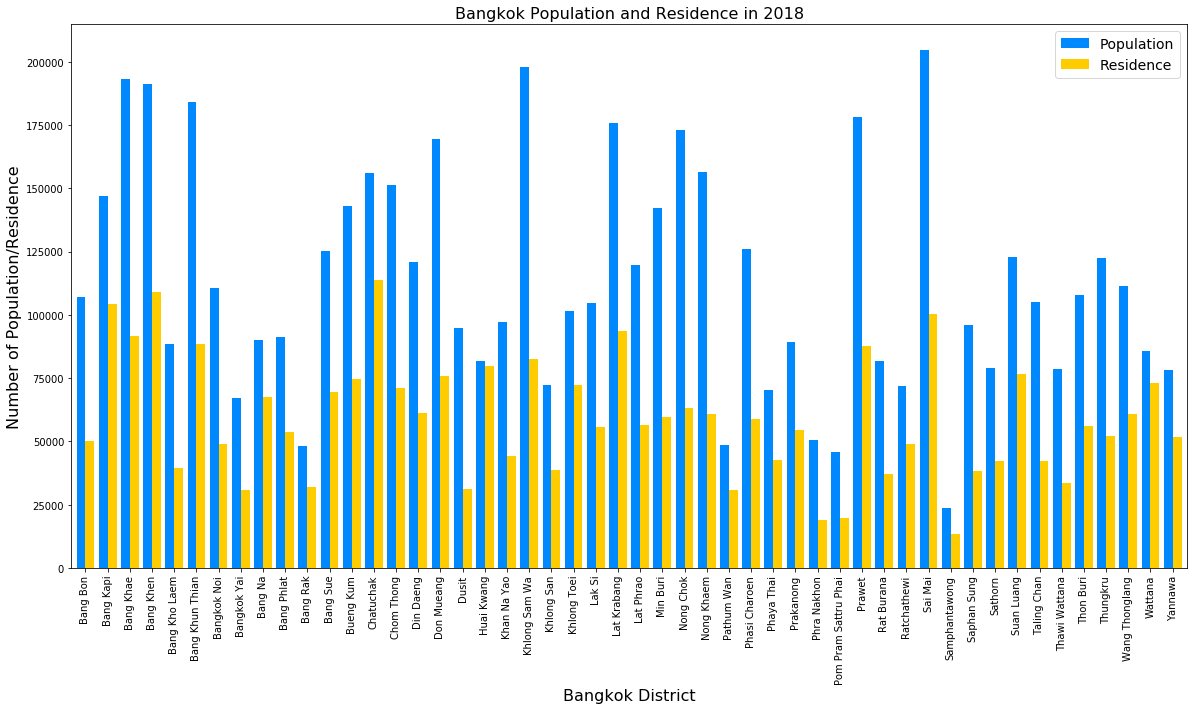

In [49]:
# plot bar chart

df_bangkok_pop2 = df_bangkok[['District_Eng', 'Population', 'Residence']]
df_bangkok_pop2

# plot data
ax = df_bangkok_pop2.plot(kind='bar',
             x='District_Eng',
             width=0.8,
             alpha=1.0,
             figsize=(20, 10),
             color=['#0089FF', '#FFCC00'],
            )

# # add % sign
# p_template = '{:.2f}%'

# # add annotate to each bar
# for p in ax.patches:
#     ax.annotate(p_template.format(p.get_height()), (p.get_x(), p.get_height()+1), fontsize=14)
    
ax.legend(fontsize=14)
ax.set_title('Bangkok Population and Residence in 2018', fontsize=16)
ax.set_ylabel('Number of Population/Residence', fontsize=16)
ax.set_xlabel('Bangkok District', fontsize=16)

# save plot
plt.savefig('bangkokPopRes2018.png')

# # Hide the left, top and right borders
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

### Let's find more insight by residence per citizen.

In [12]:
# residence per citizen

bkk_rpc_total = bkk_pop_total / bkk_res_total

print("Average Bangkok Residence per Citizen in 2018: ", bkk_rpc_total)

Average Bangkok Residence per Citizen in 2018:  1.9180949368884996


**Average Bangkok Residence per Citizen: 1.91**  
In every 1 house in bangkok, will be approximately 2 citizen are living.

Let's compute by district and add them to dataframe.

In [13]:
# create new dataframe first
rpc_dis = df_bangkok['Population'] / df_bangkok['Residence']
rpc_dis = pd.DataFrame(rpc_dis, columns = ['RpC'])

# merge to df_bangkok
df_bangkok2 = pd.concat([df_bangkok, rpc_dis], axis=1)

# sort by new column
df_bangkok2 = df_bangkok2.sort_values(by=['RpC'], ascending=False)

df_bangkok2.head()

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC
17,2,Dusit,ดุสิต,13.776944,100.520556,94854,31294,10.700,500000,3.031060
27,3,Nong Chok,หนองจอก,13.855556,100.862500,172990,63210,236.261,15600,2.736751
33,1,Phra Nakhon,พระนคร,13.764444,100.499167,50382,19101,5.536,500000,2.637663
28,23,Nong Khaem,หนองแขม,13.704722,100.348889,156267,60680,35.825,111250,2.575264
40,44,Saphan Sung,สะพานสูง,13.770000,100.684722,95836,38441,28.124,67000,2.493067


### Let's visualize.

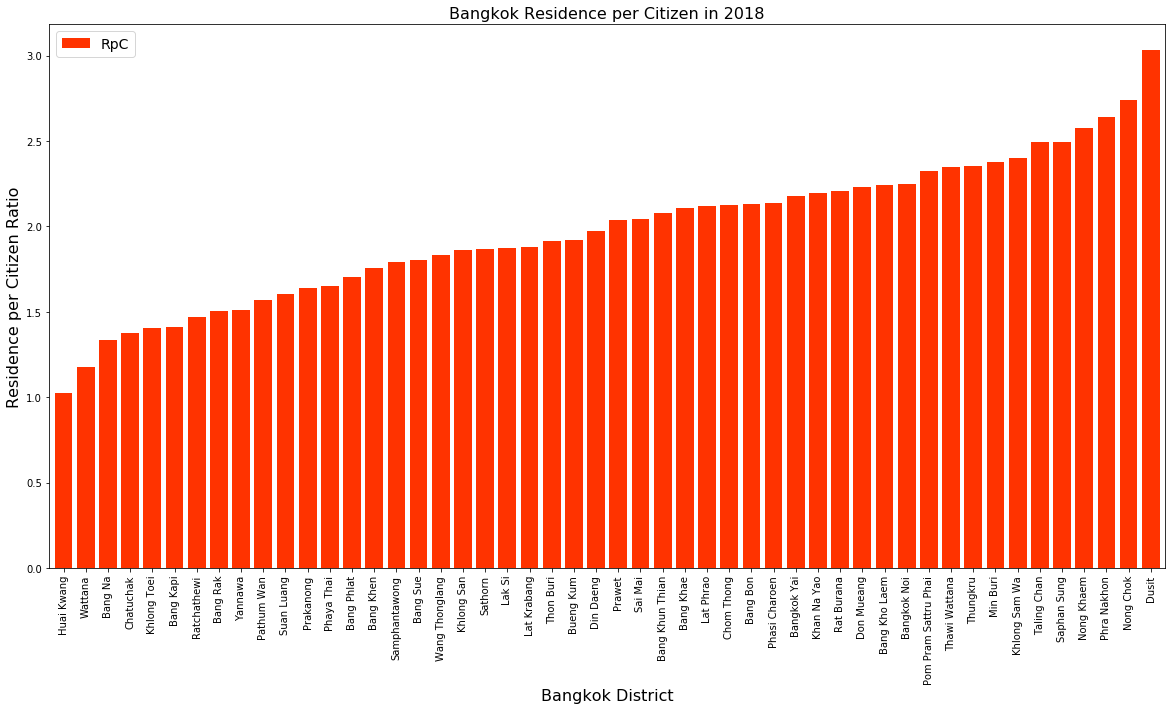

In [50]:
# sort column
df_bangkok2 = df_bangkok2.sort_values(by=['RpC'], ascending=True)

# plot bar chart

df_bangkok_pop3 = df_bangkok2[['District_Eng', 'RpC']]
df_bangkok_pop3

# plot data
ax = df_bangkok_pop3.plot(kind='bar',
             x='District_Eng',
             width=0.8,
             alpha=1.0,
             figsize=(20, 10),
             color=['#FF3300'],
            )

# # add % sign
# p_template = '{:.2f}%'

# # add annotate to each bar
# for p in ax.patches:
#     ax.annotate(p_template.format(p.get_height()), (p.get_x(), p.get_height()+1), fontsize=14)
    
ax.legend(fontsize=14)
ax.set_title('Bangkok Residence per Citizen in 2018', fontsize=16)
ax.set_ylabel('Residence per Citizen Ratio', fontsize=16)
ax.set_xlabel('Bangkok District', fontsize=16)

# save plot
plt.savefig('bangkokRpC2018.png')

# # Hide the left, top and right borders
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

### Let's visualize by Choropleth map.

In [54]:
bangkok_geo = r'bangkok_geo.json' # geojson file

# create a plain world map
bangkok_map1 = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='openstreetmap')

# generate choropleth map
bangkok_map1.choropleth(
    geo_data=bangkok_geo,
    data=df_bangkok2,
    columns=['District_Eng', 'RpC'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd', # can be reverse color by add "_r"
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Bangkok'
)

# save map
bangkok_map1.save("BangkokPop2018_c.html")

# display map
bangkok_map1

**Bangkok people seem living outer area. Maybe land price is related factor. We will analysis later.**

Now, let's take a look to another feature. We have 'Area Size' that we can find more insight about density of living by district.

In [16]:
# create new dataframe first
df_dol = df_bangkok2['Population'] / df_bangkok2['Area_Size_sqkm']
df_dol = pd.DataFrame(df_dol, columns = ['DoL'])

# merge to df_bangkok2
df_bangkok3 = pd.concat([df_bangkok2, df_dol], axis=1)

# sort by new column
df_bangkok3 = df_bangkok3.sort_values(by=['DoL'], ascending=False)

df_bangkok3.head()

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL
34,8,Pom Pram Sattru Phai,ป้อมปราบศัตรูพ่าย,13.758056,100.513056,45701,19655,1.931,500000,2.325159,23667.011911
39,13,Samphantawong,สัมพันธวงศ์,13.731389,100.514167,23655,13206,1.416,500000,1.791231,16705.508475
15,26,Din Daeng,ดินแดง,13.769722,100.552778,120761,61149,8.400,300000,1.974865,14376.309524
45,15,Thon Buri,ธนบุรี,13.725000,100.485833,107754,56237,8.551,280000,1.916069,12601.333177
21,18,Khlong San,คลองสาน,13.730278,100.509722,72171,38830,6.051,280000,1.858640,11927.119484


The density of living by district has shown above.
For example, **'Pom Pram Sattru Phai' district is highest density with 23,667 people per square kilimaters.**

### Let's visualize.

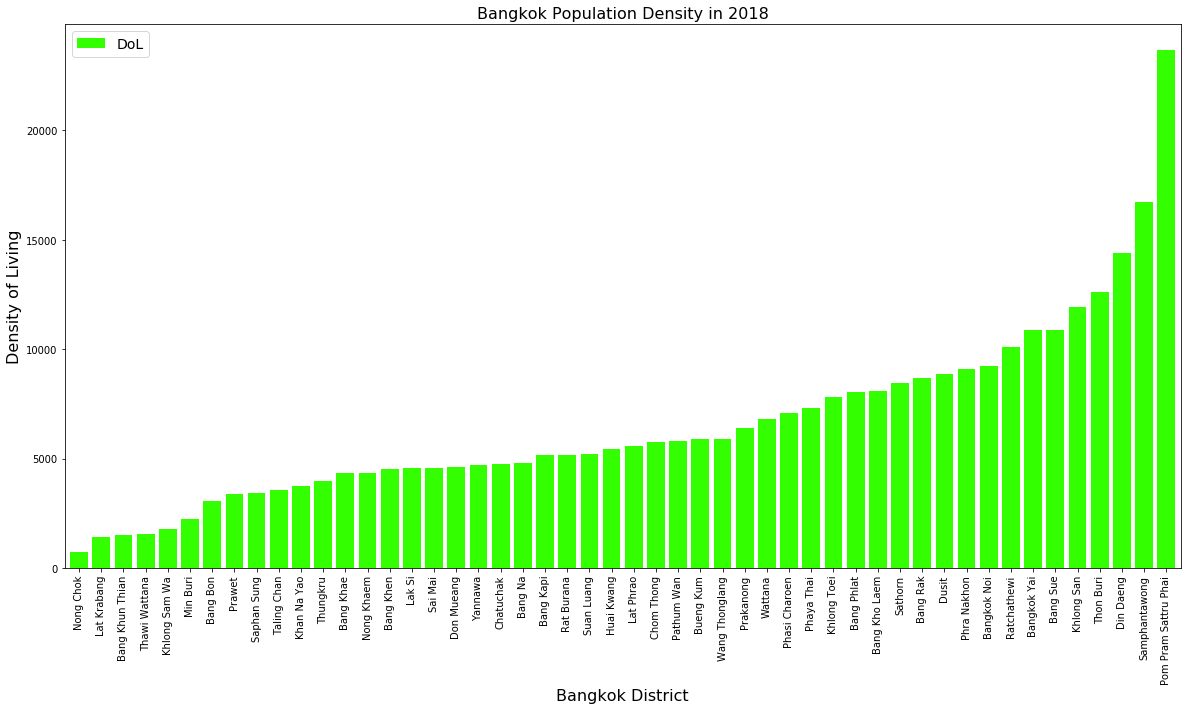

In [55]:
# sort column
df_bangkok3 = df_bangkok3.sort_values(by=['DoL'], ascending=True)

# plot bar chart

df_bangkok_pop4 = df_bangkok3[['District_Eng', 'DoL']]
df_bangkok_pop4

# plot data
ax = df_bangkok_pop4.plot(kind='bar',
             x='District_Eng',
             width=0.8,
             alpha=1.0,
             figsize=(20, 10),
             color=['#33FF00'],
            )

# # add % sign
# p_template = '{:.2f}%'

# # add annotate to each bar
# for p in ax.patches:
#     ax.annotate(p_template.format(p.get_height()), (p.get_x(), p.get_height()+1), fontsize=14)
    
ax.legend(fontsize=14)
ax.set_title('Bangkok Population Density in 2018', fontsize=16)
ax.set_ylabel('Density of Living', fontsize=16)
ax.set_xlabel('Bangkok District', fontsize=16)

# save plot
plt.savefig('bangkokPopDen2018.png')

# # Hide the left, top and right borders
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

### Let's visualize by Choropleth map.

In [56]:
bangkok_geo = r'bangkok_geo.json' # geojson file

# create a plain world map
bangkok_map2 = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='openstreetmap')

# generate choropleth map
bangkok_map2.choropleth(
    geo_data=bangkok_geo,
    data=df_bangkok3,
    columns=['District_Eng', 'DoL'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',  # can be reverse color by add "_r"
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Bangkok'
)

# save map
bangkok_map2.save("BangkokPopDen2018_c.html")

# display map
bangkok_map2

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**Center of Bangkok is the most density of population.**  
**Why people are concentrate into the middle of Bangkok? Maybe there are many well paying jobs or a lot of chance to make tons of money here?**

### Now, let's see average land prices that collected and analysis.

In [57]:
bangkok_geo = r'bangkok_geo.json' # geojson file

# create a plain world map
bangkok_map3 = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='openstreetmap')

# generate choropleth map
bangkok_map3.choropleth(
    geo_data=bangkok_geo,
    data=df_bangkok3,
    columns=['District_Eng', 'AVG_Land_Price_sqwa'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',  # can be reverse color by add "_r"
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Bangkok'
)

# save map
bangkok_map3.save("BangkokLP2018_c.html")

# display map
bangkok_map3

**For average land prices index, the more high price of land, the more concentrate into middle of Bangkok.**  
**People who live here must be wealthy.**

### Try to reverse colors and compare to other map.

In [59]:
bangkok_geo = r'bangkok_geo.json' # geojson file

# create a plain world map
bangkok_map4 = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='openstreetmap')

# generate choropleth map
bangkok_map4.choropleth(
    geo_data=bangkok_geo,
    data=df_bangkok3,
    columns=['District_Eng', 'AVG_Land_Price_sqwa'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd_r',  # can be reverse color by add "_r"
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Bangkok'
)

# save map
bangkok_map4.save("BangkokLP2018r_c.html")

# display map
bangkok_map4

**Interesting! It's similar to "Residence per Citizen" map.**  
**We can say that, middle income people generality live around the red area that affordable land and residence.**  
**This will concern to make a decision when we start some business.**

## Use Machine Learning to ensure our analysis and find more insight.

### K-Means to clustering district and find the insight.

#### Pre-processing

In [21]:
# check dataframe
df_bangkok3.head()

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL
27,3,Nong Chok,หนองจอก,13.855556,100.862500,172990,63210,236.261,15600,2.736751,732.198712
24,11,Lat Krabang,ลาดกระบัง,13.722317,100.759669,175662,93589,123.859,37500,1.876951,1418.241710
5,21,Bang Khun Thian,บางขุนเทียน,13.660833,100.435833,183878,88455,120.687,87500,2.078775,1523.594090
44,48,Thawi Wattana,ทวีวัฒนา,13.770108,100.351936,78394,33370,50.219,120000,2.349236,1561.042633
20,46,Khlong Sam Wa,คลองสามวา,13.859722,100.704167,198019,82412,110.686,70000,2.402793,1789.015774


In [22]:
# Drop code and district name because no meaning for Euclidean distance function in k-means
df_bangkok_kmeans = df_bangkok3.drop(['Code','District_Eng','District_Thai'], axis=1)
df_bangkok_kmeans.head()

,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL
27,13.855556,100.862500,172990,63210,236.261,15600,2.736751,732.198712
24,13.722317,100.759669,175662,93589,123.859,37500,1.876951,1418.241710
5,13.660833,100.435833,183878,88455,120.687,87500,2.078775,1523.594090
44,13.770108,100.351936,78394,33370,50.219,120000,2.349236,1561.042633
20,13.859722,100.704167,198019,82412,110.686,70000,2.402793,1789.015774


### Normalizing over the standard deviation

In [23]:
from sklearn.preprocessing import StandardScaler
X = df_bangkok_kmeans.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 2.99825687e+00,  1.33899478e+00,  1.70134461e-01,
         5.14641464e+00, -1.31281069e+00,  1.82837527e+00,
        -1.40811940e+00],
       [ 1.99633034e+00,  1.39916922e+00,  1.45598820e+00,
         2.32332101e+00, -1.17947603e+00, -2.32071044e-01,
        -1.24265578e+00],
       [-1.15894269e+00,  1.58419661e+00,  1.23868107e+00,
         2.24365292e+00, -8.75058979e-01,  2.51583534e-01,
        -1.21724632e+00],
       [-1.97639103e+00, -7.91342520e-01, -1.09290499e+00,
         4.73775500e-01, -6.77187898e-01,  8.99724472e-01,
        -1.20821427e+00],
       [ 1.45555055e+00,  1.90265722e+00,  9.82898655e-01,
         1.99246736e+00, -9.81604946e-01,  1.02807100e+00,
        -1.15323046e+00],
       [ 1.88317990e+00,  6.48092223e-01,  2.67303845e-02,
         8.10983512e-01, -9.81604946e-01,  9.70830273e-01,
        -1.04542139e+00],
       [-1.88963652e+00, -1.48948853e-01, -3.78889825e-01,
         8.51298280e-02, -8.75058979e-01,  3.70045298e-01,
        -8.4252741

### Modeling and Training

In [24]:
# set cluster to 6
clusterNum = 6
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 20)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[5 5 3 0 5 5 0 3 0 0 0 2 3 3 3 0 3 5 1 3 4 3 2 0 2 0 5 1 5 0 4 4 0 2 4 0 1
 1 1 1 1 0 2 2 1 2 2 2 1 1]


We assign the labels to each row in dataframe.

In [25]:
df_bangkok3_clus = df_bangkok3
df_bangkok3_clus["Clus_km"] = labels
df_bangkok3_clus.head(5)

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
27,3,Nong Chok,หนองจอก,13.855556,100.862500,172990,63210,236.261,15600,2.736751,732.198712,5
24,11,Lat Krabang,ลาดกระบัง,13.722317,100.759669,175662,93589,123.859,37500,1.876951,1418.241710,5
5,21,Bang Khun Thian,บางขุนเทียน,13.660833,100.435833,183878,88455,120.687,87500,2.078775,1523.594090,3
44,48,Thawi Wattana,ทวีวัฒนา,13.770108,100.351936,78394,33370,50.219,120000,2.349236,1561.042633,0
20,46,Khlong Sam Wa,คลองสามวา,13.859722,100.704167,198019,82412,110.686,70000,2.402793,1789.015774,5


Check the cendriod.

In [26]:
df_bangkok3_clus.groupby('Clus_km').mean()

,Code,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL
Clus_km,,,,,,,,,
0,38.333333,13.766392,100.542339,105805.333333,51642.916667,24.717417,101062.500000,2.098471,5076.915188
1,13.800000,13.736775,100.508541,68165.900000,34895.100000,8.190200,500000.000000,2.028149,10493.911329
2,25.000000,13.738021,100.521509,88442.333333,49724.333333,11.939889,288888.888889,1.847841,9089.354697
3,24.875000,13.770764,100.542291,176296.125000,94447.875000,50.204625,112625.000000,1.921611,4080.337528
4,21.250000,13.720833,100.573889,91642.500000,66784.250000,14.585000,355000.000000,1.388612,6451.320696
5,24.000000,13.803942,100.688286,164629.285714,74374.142857,88.832857,61085.714286,2.238363,3201.706151


## Traning result and Analysis

### Cluster Label 0:

In [27]:
df_bangkok3_clus0 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 0]
df_bangkok3_clus0

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
44,48,Thawi Wattana,ทวีวัฒนา,13.770108,100.351936,78394,33370,50.219,120000,2.349236,1561.042633,0
0,50,Bang Bon,บางบอน,13.657732,100.360839,106919,50239,34.745,87500,2.128207,3077.248525,0
40,44,Saphan Sung,สะพานสูง,13.770000,100.684722,95836,38441,28.124,67000,2.493067,3407.623382,0
43,19,Taling Chan,ตลิ่งชัน,13.776944,100.456667,105047,42138,29.479,120000,2.492928,3563.451949,0
19,43,Khan Na Yao,คันนายาว,13.819132,100.657954,97187,44234,25.980,67000,2.197111,3740.839107,0
23,41,Lak Si,หลักสี่,13.887500,100.578889,104577,55802,22.841,80000,1.874073,4578.477300,0
42,34,Suan Luang,สวนหลวง,13.730278,100.651389,123026,76684,23.678,115000,1.604324,5195.793564,0
25,38,Lat Phrao,ลาดพร้าว,13.803611,100.607500,119709,56470,21.500,80000,2.119869,5567.860465,0
47,45,Wang Thonglang,วังทองหลาง,13.776879,100.591925,111293,60679,18.905,125000,1.834127,5886.961121,0
30,22,Phasi Charoen,ภาษีเจริญ,13.714722,100.437222,125981,58891,17.834,111250,2.139223,7064.091062,0


In [28]:
# avg column
df_bangkok3_clus0_LP = pd.Series(df_bangkok3_clus0['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus0_DoL = pd.Series(df_bangkok3_clus0['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus0_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus0_DoL), ','), " people/sqkm")

LP:  101,062  THB/sqwa
DoL:  5,077  people/sqkm


**Cluster Label 0: Mid-Low land price and mid population density group. (next to border of Bangkok)**

### Cluster Label 1:

In [29]:
df_bangkok3_clus1 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 1]
df_bangkok3_clus1

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
49,12,Yannawa,ยานนาวา,13.696944,100.543056,78031,51655,16.662,500000,1.510619,4683.171288,1
29,7,Pathum Wan,ปทุมวัน,13.744942,100.522200,48382,30793,8.370,500000,1.571201,5780.406213,1
4,31,Bang Kho Laem,บางคอแหลม,13.693333,100.502500,88288,39353,10.921,500000,2.243488,8084.241370,1
41,28,Sathorn,สาทร,13.708056,100.526389,78860,42255,9.326,500000,1.866288,8455.929659,1
10,20,Bang Rak,บางรัก,13.770867,100.467933,48207,32045,5.540,500000,1.504353,8701.624549,1
17,2,Dusit,ดุสิต,13.776944,100.520556,94854,31294,10.700,500000,3.031060,8864.859813,1
33,1,Phra Nakhon,พระนคร,13.764444,100.499167,50382,19101,5.536,500000,2.637663,9100.794798,1
11,16,Bang Sue,บางซื่อ,13.722778,100.476389,125299,69594,11.500,500000,1.800428,10895.565217,1
39,13,Samphantawong,สัมพันธวงศ์,13.731389,100.514167,23655,13206,1.416,500000,1.791231,16705.508475,1
34,8,Pom Pram Sattru Phai,ป้อมปราบศัตรูพ่าย,13.758056,100.513056,45701,19655,1.931,500000,2.325159,23667.011911,1


In [30]:
# avg column
df_bangkok3_clus1_LP = pd.Series(df_bangkok3_clus1['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus1_DoL = pd.Series(df_bangkok3_clus1['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus1_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus1_DoL), ','), " people/sqkm")

LP:  500,000  THB/sqwa
DoL:  10,494  people/sqkm


**Cluster Label 1: Very high land price and very high population density group. (at the center and nearly center of Bangkok)**

### Cluster Label 2:

In [31]:
df_bangkok3_clus2 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 2]
df_bangkok3_clus2

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
46,49,Thungkru,ทุ่งครุ,13.625519,100.478030,122296,51957,30.741,280000,2.353793,3978.270063,2
36,24,Rat Burana,ราษฎร์บูรณะ,13.682222,100.505556,81806,37036,15.782,280000,2.208824,5183.500190,2
18,17,Huai Kwang,ห้วยขวาง,13.776667,100.579444,81689,79768,15.033,300000,1.024082,5433.978580,2
31,14,Phaya Thai,พญาไท,13.780000,100.542778,70341,42662,9.595,300000,1.648798,7331.005732,2
37,37,Ratchathewi,ราชเทวี,13.758889,100.534444,71952,49014,7.126,300000,1.467989,10097.109178,2
7,25,Bangkok Yai,บางกอกใหญ่,13.793889,100.505000,67211,30866,6.180,280000,2.177509,10875.566343,2
21,18,Khlong San,คลองสาน,13.730278,100.509722,72171,38830,6.051,280000,1.858640,11927.119484,2
45,15,Thon Buri,ธนบุรี,13.725000,100.485833,107754,56237,8.551,280000,1.916069,12601.333177,2
15,26,Din Daeng,ดินแดง,13.769722,100.552778,120761,61149,8.400,300000,1.974865,14376.309524,2


In [32]:
# avg column
df_bangkok3_clus2_LP = pd.Series(df_bangkok3_clus2['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus2_DoL = pd.Series(df_bangkok3_clus2['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus2_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus2_DoL), ','), " people/sqkm")

LP:  288,889  THB/sqwa
DoL:  9,089  people/sqkm


**Cluster Label 2: Mid-High land price and high population density group. (between center area and downtown of Bangkok)**

### Cluster Label 3:

In [33]:
df_bangkok3_clus3 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 3]
df_bangkok3_clus3

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
5,21,Bang Khun Thian,บางขุนเทียน,13.660833,100.435833,183878,88455,120.687,87500,2.078775,1523.594090,3
35,32,Prawet,ประเวศ,13.716944,100.694444,178290,87588,52.500,115000,2.035553,3396.000000,3
2,40,Bang Khae,บางแค,13.696111,100.409444,193315,91765,44.456,111250,2.106631,4348.456901,3
28,23,Nong Khaem,หนองแขม,13.704722,100.348889,156267,60680,35.825,111250,2.575264,4361.953943,3
3,5,Bang Khen,บางเขน,13.873889,100.596389,191323,109112,42.123,86750,1.753455,4542.007929,3
38,42,Sai Mai,สายไหม,13.919167,100.645833,204532,100196,44.615,86750,2.041319,4584.377452,3
13,30,Chatuchak,จตุจักร,13.828611,100.559722,155923,113553,32.908,177500,1.373130,4738.148778,3
1,6,Bang Kapi,บางกะปิ,13.765833,100.647778,146841,104234,28.523,125000,1.408763,5148.161133,3


In [34]:
# avg column
df_bangkok3_clus3_LP = pd.Series(df_bangkok3_clus3['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus3_DoL = pd.Series(df_bangkok3_clus3['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus3_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus3_DoL), ','), " people/sqkm")

LP:  112,625  THB/sqwa
DoL:  4,080  people/sqkm


**Cluster Label 3: Mid land price and mid-low population density group. (a litte far and next to middle of Bangkok)**

### Cluster Label 4:

In [35]:
df_bangkok3_clus4 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 4]
df_bangkok3_clus4

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
8,4,Bang Na,บางนา,13.730833,100.524167,90148,67609,18.789,355000,1.333373,4797.913673,4
32,9,Prakanong,พระโขนง,13.702222,100.601667,89237,54409,13.986,355000,1.640115,6380.451880,4
48,39,Wattana,วัฒนา,13.742222,100.585833,85642,72939,12.565,355000,1.174159,6815.917230,4
22,33,Khlong Toei,คลองเตย,13.708056,100.583889,101543,72180,13.000,355000,1.406802,7811.000000,4


In [36]:
# avg column
df_bangkok3_clus4_LP = pd.Series(df_bangkok3_clus4['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus4_DoL = pd.Series(df_bangkok3_clus4['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus4_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus4_DoL), ','), " people/sqkm")

LP:  355,000  THB/sqwa
DoL:  6,451  people/sqkm


**Cluster Label 4: High land price and mid-high population density group. (next to middle of Bangkok)**

### Cluster Label 5:

In [37]:
df_bangkok3_clus5 = df_bangkok3_clus.loc[df_bangkok3_clus['Clus_km'] == 5]
df_bangkok3_clus5

,Code,District_Eng,District_Thai,Latitude,Longitude,Population,Residence,Area_Size_sqkm,AVG_Land_Price_sqwa,RpC,DoL,Clus_km
27,3,Nong Chok,หนองจอก,13.855556,100.862500,172990,63210,236.261,15600,2.736751,732.198712,5
24,11,Lat Krabang,ลาดกระบัง,13.722317,100.759669,175662,93589,123.859,37500,1.876951,1418.241710,5
20,46,Khlong Sam Wa,คลองสามวา,13.859722,100.704167,198019,82412,110.686,70000,2.402793,1789.015774,5
26,10,Min Buri,มีนบุรี,13.813889,100.748056,142311,59822,63.645,70000,2.378907,2236.012255,5
16,36,Don Mueang,ดอนเมือง,13.913611,100.589722,169259,75954,36.803,80000,2.228441,4599.054425,5
14,35,Chom Thong,จอมทอง,13.677222,100.484722,151174,71106,26.265,87500,2.126037,5755.720541,5
12,27,Bueng Kum,บึงกุ่ม,13.785278,100.669167,142990,74526,24.311,67000,1.918659,5881.699642,5


In [38]:
# avg column
df_bangkok3_clus5_LP = pd.Series(df_bangkok3_clus5['AVG_Land_Price_sqwa']).mean()
df_bangkok3_clus5_DoL = pd.Series(df_bangkok3_clus5['DoL']).mean()

print("LP: ", format(round(df_bangkok3_clus5_LP), ','), " THB/sqwa")
print("DoL: ", format(round(df_bangkok3_clus5_DoL), ','), " people/sqkm")

LP:  61,086  THB/sqwa
DoL:  3,202  people/sqkm


**Cluster Label 5: Mid land price and mid-low population density group. (next to middle of Bangkok)**

Now, we understand insight of Bangkok. Let's move to the next section.

## 3. Foursquare API to Analysis and make decision to start some business.

This section we will use Foursqure API to find that what kind of food business will be more suitable to start. It's depend on stakeholder's interest.    
But for me, **I want to find that the center area of Bangkok, what kind of food business will be most interesting.**

#### Recall Foursquare API request parameters

In [2]:
# Foursquare API request parameters
CLIENT_ID = 'hidden-id' # your Foursquare ID
CLIENT_SECRET = 'hidden-secret' # your Foursquare Secret
VERSION = '20180604'
radius = 50000
LIMIT = 100

# create URL for request explore parameter.
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('\nURL:\n' + url)

NameError: name 'latitude' is not defined

**Recall center area of Bangkok.**

In [40]:
# Siam, Center of Bangkok
latitude = 13.7456058
longitude = 100.5341187
print("Bangkok: ", latitude, longitude)

Bangkok:  13.7456058 100.5341187


**Setting up request URL for searching "Food" category of venues.**

In [3]:
# search
search_query = 'food'
radius = 10000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

NameError: name 'latitude' is not defined

Getting result from Foursquare API

In [42]:
results = requests.get(url).json()
'There are {} places around Center Area of Bangkok.'.format(len(results['response']['venues']))

'There are 50 places around Center Area of Bangkok.'

Search result was limited 50 items by the API. (Free Account?)

See the result by normalize json file.

In [43]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",False,4b52bd5af964a5202b8727e3,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,G Fl.,120,"[Siam Paragon (G Fl.), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74570260988103...",13.745703,100.535227,NaN,10330,กรุงเทพมหานคร,Paragon Food Hall (ฟู้ดฮอลล์),v-1556392248,NaN
1,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",False,50f03dc2e4b0db6493a73a68,Siam Center,TH,ปทุมวัน,ประเทศไทย,2nd Fl,133,"[Siam Center (2nd Fl), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74622624188325...",13.746226,100.533065,NaN,10330,กรุงเทพมหานคร,Food Republic (ฟู้ด รีพับลิค),v-1556392248,NaN
2,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",False,4ba481cef964a5203aa138e3,MBK Center,TH,ปทุมวัน,ประเทศไทย,"6th Fl., Tokyu Zone",406,"[MBK Center (6th Fl., Tokyu Zone), ปทุมวัน, กร...","[{'label': 'display', 'lat': 13.74588350973425...",13.745884,100.530366,NaN,10330,กรุงเทพมหานคร,MBK Food Island,v-1556392248,NaN
3,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4b586543f964a520dc5528e3,CentralWorld,TH,ปทุมวัน,ประเทศไทย,"7th Fl, Dazzle Zone",548,"[CentralWorld (7th Fl, Dazzle Zone), ปทุมวัน, ...","[{'label': 'display', 'lat': 13.74673913724016...",13.746739,100.539059,NaN,10330,กรุงเทพมหานคร,Central Food Hall (เซ็นทรัล ฟู้ด ฮอลล์),v-1556392248,NaN
4,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",False,4d4a3a119526b60c634080ee,Big C Rajdamri,TH,ปทุมวัน,ประเทศไทย,4th Fl.,812,"[Big C Rajdamri (4th Fl.), ปทุมวัน, กรุงเทพมหา...","[{'label': 'display', 'lat': 13.74690591333071...",13.746906,100.541517,NaN,10330,กรุงเทพมหานคร,Food Park,v-1556392248,NaN


Cleaning data for easy reading format.

In [44]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Paragon Food Hall (ฟู้ดฮอลล์),Food Court,Siam Paragon,TH,ปทุมวัน,ประเทศไทย,G Fl.,120,"[Siam Paragon (G Fl.), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74570260988103...",13.745703,100.535227,NaN,10330,กรุงเทพมหานคร,4b52bd5af964a5202b8727e3
1,Food Republic (ฟู้ด รีพับลิค),Food Court,Siam Center,TH,ปทุมวัน,ประเทศไทย,2nd Fl,133,"[Siam Center (2nd Fl), ปทุมวัน, กรุงเทพมหานคร ...","[{'label': 'display', 'lat': 13.74622624188325...",13.746226,100.533065,NaN,10330,กรุงเทพมหานคร,50f03dc2e4b0db6493a73a68
2,MBK Food Island,Food Court,MBK Center,TH,ปทุมวัน,ประเทศไทย,"6th Fl., Tokyu Zone",406,"[MBK Center (6th Fl., Tokyu Zone), ปทุมวัน, กร...","[{'label': 'display', 'lat': 13.74588350973425...",13.745884,100.530366,NaN,10330,กรุงเทพมหานคร,4ba481cef964a5203aa138e3
3,Central Food Hall (เซ็นทรัล ฟู้ด ฮอลล์),Supermarket,CentralWorld,TH,ปทุมวัน,ประเทศไทย,"7th Fl, Dazzle Zone",548,"[CentralWorld (7th Fl, Dazzle Zone), ปทุมวัน, ...","[{'label': 'display', 'lat': 13.74673913724016...",13.746739,100.539059,NaN,10330,กรุงเทพมหานคร,4b586543f964a520dc5528e3
4,Food Park,Food Court,Big C Rajdamri,TH,ปทุมวัน,ประเทศไทย,4th Fl.,812,"[Big C Rajdamri (4th Fl.), ปทุมวัน, กรุงเทพมหา...","[{'label': 'display', 'lat': 13.74690591333071...",13.746906,100.541517,NaN,10330,กรุงเทพมหานคร,4d4a3a119526b60c634080ee
5,Food Court (ศูนย์อาหาร),Food Court,Platinum Fashion Mall,TH,ราชเทวี,ประเทศไทย,7th Fl.,805,"[Platinum Fashion Mall (7th Fl.), ราชเทวี, กรุ...","[{'label': 'display', 'lat': 13.75061143465614...",13.750611,100.539500,NaN,10400,กรุงเทพมหานคร,4d943a3d58caa143c1dba525
6,Faculty of Dentistry Food Court (ศูนย์อาหารคณะ...,College Cafeteria,Faculty of Dentistry,TH,ปทุมวัน,ประเทศไทย,Chulalongkorn University,278,[Faculty of Dentistry (Chulalongkorn Universit...,"[{'label': 'display', 'lat': 13.74322973688012...",13.743230,100.533303,NaN,10330,กรุงเทพมหานคร,4c469a1631e41b8dbd5b4a35
7,Food +Plus @ Siam Square,Food Court,"Siam Square Soi 5, Pathumwan",TH,พระนคร,ประเทศไทย,"(behind Bangkok Bank, Siam Square Branch)",107,"[Siam Square Soi 5, Pathumwan ((behind Bangkok...","[{'label': 'display', 'lat': 13.74518748193419...",13.745187,100.535019,NaN,10330,กรุงเทพมหานคร,4ccbf5cfee23a143d01b1ba8
8,Central Food Hall (เซ็นทรัล ฟู้ด ฮอลล์),Supermarket,Central Chidlom,TH,ปทุมวัน,ประเทศไทย,G Fl.,1261,"[Central Chidlom (G Fl.), ปทุมวัน, กรุงเทพมหาน...","[{'label': 'display', 'lat': 13.74460468218932...",13.744605,100.545739,NaN,10330,กรุงเทพมหานคร,4b6c2e97f964a5200c282ce3
9,Pantip Plaza Food Street,Food Court,Pantip Plaza Pratunam,TH,NaN,ประเทศไทย,4th Fl.,589,"[Pantip Plaza Pratunam (4th Fl.), ประเทศไทย]","[{'label': 'display', 'lat': 13.750148, 'lng':...",13.750148,100.536924,NaN,NaN,NaN,58267db9878188626a4f53fe


Visualize Foursquare's venues on the map.

In [60]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Bangkok

# add Center of Bangkok as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Siam',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add result food spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# save map
venues_map.save("CenterBangkok_venues.html")

# display map
venues_map

### Add marker together with Land Prices choropleth map (weathly people area)

In [61]:
bangkok_geo = r'bangkok_geo.json' # geojson file

# create a plain world map
bangkok_map3 = folium.Map(location=[latitude, longitude], zoom_start=13, tiles='openstreetmap')

# generate choropleth map
bangkok_map3.choropleth(
    geo_data=bangkok_geo,
    data=df_bangkok3,
    columns=['District_Eng', 'AVG_Land_Price_sqwa'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',  # can be reverse color by add "_r"
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Bangkok'
)

# add Center of Bangkok as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Siam',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(bangkok_map3)


# add result food spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(bangkok_map3)

# save map
bangkok_map3.save("CenterBangkok_venues_c.html")    

# display map
bangkok_map3

The red and orange area are:  
**Cluster Label 0: Very high land price and very high population density group. (at the center and nearly center of Bangkok)**  
and  
**Cluster Label 4: High land price and mid-high population density group. (next to middle of Bangkok)**  

That's many of weathly people there, maybe a good chance to do this food business!

#### Counting food category from search result.

In [47]:
dataframe_filtered.groupby('categories').count()

,name,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
categories,,,,,,,,,,,,,,,
Chinese Restaurant,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
College Cafeteria,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
Cosmetics Shop,2,2,2,1,2,1,2,2,2,2,2,0,1,1,2
Food & Drink Shop,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
Food Court,27,27,27,25,27,19,27,27,27,27,27,3,23,25,27
Food Truck,2,2,2,2,2,1,2,2,2,2,2,0,1,2,2
Market,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1
Noodle House,3,2,3,3,3,2,3,3,3,3,3,1,2,3,3
Restaurant,2,2,2,2,2,1,2,2,2,2,2,0,2,2,2


Great! the result was showing that "Food Court" category is the most popular in this area. Other food category with a fews and separately.  
**To start food business in this area, there will be yet a good chance with any kind of food category without most popular one (Food Court).**